# River Water Quality Prediction

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
modelsPath = './models'
dataPath = "./data"
figsPath = './figs'

stations = ['Old Derry', 'MGCC']

*optional*

In [ ]:
!python "./cleaning_data.py"

## Spatio-Temporal LSTM
### Data

In [3]:
crwq = []
for station in stations:
    df = pd.read_csv(f"{dataPath}/{station}.csv")
    print(min(df['time']), max(df['time']))    # check timestamps
    
    crwq.append(df['value'].to_list())


2012-04-19 15:00:00 2016-11-04 19:00:00
2012-04-19 15:00:00 2016-11-04 19:00:00


### Training

SP_Learner(data, train_time, predict_time, predict_position,Stride, start, end, data_name)

+ data: The original Input data, with missing value masked as -1
  - *the masked data for learning and original interpolated data for predicting*
+ train_time: length of batch train data
+ predict_time: #{target value}
+ predict_position: difference b/w (now + train_time) and time index of the predicted
+ Stride: #{feature} + #{target value}
+ start, end: the portion of the test dataset, for example if ```start = .8, end= 1```, we use the last 20%


In [4]:
## only using CPU (faster than GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from model import py_ty_plot, SP_Learner

Num GPUs Available:  0


In [5]:
n_ahead = 2    # 2-hour ahead prediction
train_hour = 6

p1, p2 = .8, 1
n_features = 6
predict_hour = 1
stride = n_features + predict_hour
predict_position = n_ahead * stride + (n_features - train_hour)

########################Start##################################


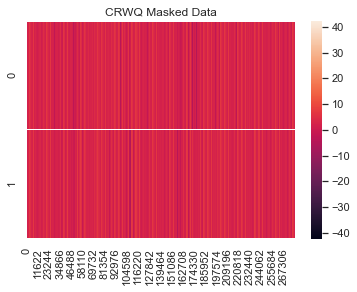

<Figure size 432x288 with 0 Axes>

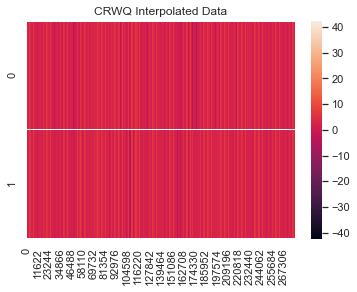

<Figure size 432x288 with 0 Axes>

Training Data Length:  2 X 223132
Test Data Length:  2 X 55783
Testing percentage:  20.0 %
Total data size:  2 X 278915
Train data size(batch, row, column) Train X:  (31874, 2, 6)  ,Train Y:  (31874, 2, 1)
test data size(batch, row, column) Test X:  (7967, 2, 6)  ,Test Y:  (7967, 2, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 2, 6)              0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2, 64)             9984      
_________________________________________________________________
dense (Dense)                (None, 2, 1)              65        
Total params: 10,049
Trainable params: 10,049
Non-trainable params: 0
_________________________________________________________________
Total compile time: -------- 369.00664900000004 s
249/249 [==============================] - 0s

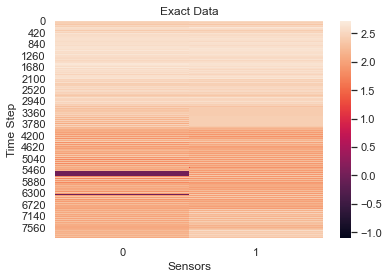

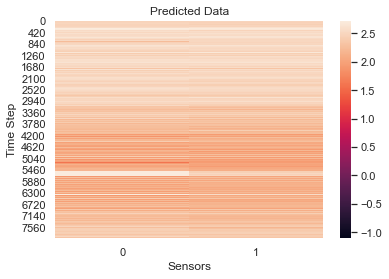

error shape:  (7967, 2)


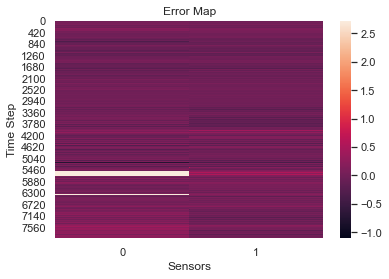

predict data size:  2 7967
exact data size:  2 7967
Predicted Data Point size for sensor 1  7967
2.6313491261719397 0.23895660177386027
Predicted Data Point size for sensor 2  7967
2.555869801220242 0.08791533068334415
MAE:  0.1634359662286022 STD:  0.5703535619337912
########################End##################################


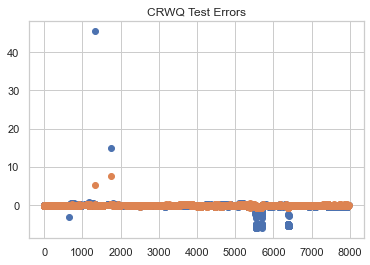

In [6]:
crwq_py, crwq_ty, crwq_error, crwq_sd, crwq_model = SP_Learner(crwq, train_hour, predict_hour, predict_position, stride, p1, p2, 'CRWQ')

In [7]:
crwq_model.save(f'{modelsPath}/sp_lstm_{n_ahead}h.h5')

### Results

In [8]:
df = pd.DataFrame(columns=stations, index=["MAE", "STD"])
df.loc["MAE", :] = crwq_error
df.loc["STD", :] = crwq_sd
df["Total"] = [np.mean(crwq_error), np.mean(crwq_sd)]
df.to_csv(f'{modelsPath}/performance_sp_lstm_{n_ahead}h.csv')

df

,Old Derry,MGCC,Total
MAE,0.238957,0.087915,0.163436
STD,0.980035,0.160672,0.570354


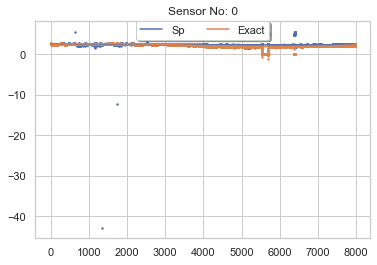

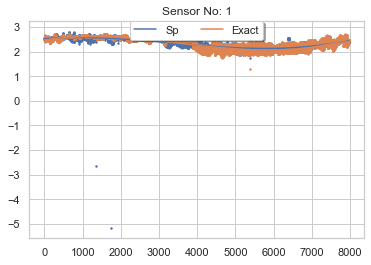

In [9]:
for i in range(len(stations)):
    py_ty_plot(crwq_py, crwq_ty, 2, 100, 'CRWQ_sensor_plot', i, n_ahead)


**Load Results**

In [10]:
crwq_model = tf.keras.models.load_model(f'{modelsPath}/sp_lstm_{n_ahead}h.h5')

res_test = pd.read_csv(f'{modelsPath}/results_sp_lstm_{n_ahead}h.csv', index_col=0).to_numpy()
crwq_py = res_test[:, :2].T
crwq_ty = res_test[:, 2:].T

mea_test = pd.read_csv(f'{modelsPath}/performance_sp_lstm_{n_ahead}h.csv', index_col=0)
crwq_error = mea_test.loc['MAE', ['Old Derry', 'MGCC']].to_numpy()
crwq_sd = mea_test.loc['STD', ['Old Derry', 'MGCC']].to_numpy()

## Classical LSTM

*restart kernal to activate GPU*

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from classical_lstm import split_train_test, lstm

Num GPUs Available:  1


### Data

In [4]:
data = pd.read_csv(f"{dataPath}/wide_CRWQ.csv")
data.head(3)

,time,Air Temp_Old Derry,Water Temp_Old Derry,Chloride Concentration_Old Derry,pH_Old Derry,Specific Conductivity_Old Derry,Turbidity_Old Derry,Dissolved Oxygen_Old Derry,Air Temp_MGCC,Water Temp_MGCC,Chloride Concentration_MGCC,pH_MGCC,Specific Conductivity_MGCC,Turbidity_MGCC,Dissolved Oxygen_MGCC
0,2012-04-19 15:00:00,3.006425,2.366967,4.575638,2.140066,6.606650,1.252763,2.424803,2.593013,2.468523,4.718052,2.116256,6.733402,0.810930,2.462576
1,2012-04-19 16:00:00,3.023226,2.435585,4.563280,2.140066,6.593045,1.064711,2.438208,2.715522,2.541011,4.731803,2.125251,6.733402,0.405465,2.461937
2,2012-04-19 17:00:00,3.149097,2.516284,4.541511,2.140066,6.586172,1.131402,2.444519,2.723103,2.627382,4.758106,2.128232,6.733402,0.500775,2.440824


In [5]:
data.columns

Index(['time', 'Air Temp_Old Derry', 'Water Temp_Old Derry',
       'Chloride Concentration_Old Derry', 'pH_Old Derry',
       'Specific Conductivity_Old Derry', 'Turbidity_Old Derry',
       'Dissolved Oxygen_Old Derry', 'Air Temp_MGCC', 'Water Temp_MGCC',
       'Chloride Concentration_MGCC', 'pH_MGCC', 'Specific Conductivity_MGCC',
       'Turbidity_MGCC', 'Dissolved Oxygen_MGCC'],
      dtype='object')

In [6]:
feature_names = ['Air Temp_Old Derry', 'Water Temp_Old Derry', 'Chloride Concentration_Old Derry', 'pH_Old Derry', 
                 'Specific Conductivity_Old Derry', 'Turbidity_Old Derry', 
                 'Dissolved Oxygen_Old Derry', 
                 'Air Temp_MGCC', 'Water Temp_MGCC', 'Chloride Concentration_MGCC', 'pH_MGCC', 
                 'Specific Conductivity_MGCC', 'Turbidity_MGCC']
target_names = ['Dissolved Oxygen_MGCC']

n_ahead = 2
n_time_step = 6
stride = 7
sampling_rate = 1
p1, p2 = .8, 1

*optional*

In [ ]:
help(split_train_test)

In [ ]:
X_train, Y_train, X_test, Y_test = split_train_test(data, feature_names, target_names, 
                                                   n_ahead, n_time_step, stride, sampling_rate, 
                                                   p1, p2)

In [ ]:
np.save(f"{dataPath}/X_train_LSTM.npy", X_train)
np.save(f"{dataPath}/Y_train_LSTM.npy", Y_train)
np.save(f"{dataPath}/X_test_LSTM.npy", X_test)
np.save(f"{dataPath}/Y_test_LSTM.npy", Y_test)

### Training

In [7]:
X_train = np.load(f"{dataPath}/X_train_LSTM.npy")
Y_train = np.load(f"{dataPath}/Y_train_LSTM.npy")
X_test = np.load(f"{dataPath}/X_test_LSTM.npy")
Y_test = np.load(f"{dataPath}/Y_test_LSTM.npy")

In [8]:
print(f'The size of X_train: {X_train.shape}\t\t Y_train: {Y_train.shape}')
print(f'The size of X_test: {X_test.shape}\t\t Y_test: {Y_test.shape}')

The size of X_train: (4553, 6, 13)		 Y_train: (4553, 1, 1)
The size of X_test: (1138, 6, 13)		 Y_test: (1138, 1, 1)


In [9]:
model = lstm(n_time_step=X_train.shape[1], input_dim=X_train.shape[2], n_ahead=n_ahead)

In [10]:
MAE, STD, Y_pred, Y_test, regressor = model.eval(X_train, Y_train, X_test, Y_test)

2021-08-11 02:32:05.504013
Epoch 1/100
143/143 [==============================] - 6s 7ms/step - loss: 0.3762 - accuracy: 0.0000e+00
Epoch 2/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0099 - accuracy: 0.0000e+00
Epoch 3/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0090 - accuracy: 0.0000e+00
Epoch 4/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0091 - accuracy: 0.0000e+00
Epoch 5/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0089 - accuracy: 0.0000e+00
Epoch 6/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0087 - accuracy: 0.0000e+00
Epoch 7/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0089 - accuracy: 0.0000e+00
Epoch 8/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0085 - accuracy: 0.0000e+00
Epoch 9/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0090 - accuracy: 0.0000e+00
Epoch 10/100
143/143 [======

143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 79/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 80/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 81/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 82/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 83/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 84/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 85/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 86/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 87/100
143/143 [==============================] - 1s 

In [11]:
regressor.save(f'{modelsPath}/lstm_{n_ahead}h.h5')

### Results

In [12]:
df = pd.DataFrame(columns=stations, index=["MAE", "STD"])
df['MGCC'] = (MAE, STD)
df.to_csv(f'{modelsPath}/performance_lstm_{n_ahead}h.csv')

df

,Old Derry,MGCC
MAE,NaN,0.087468
STD,NaN,0.170291


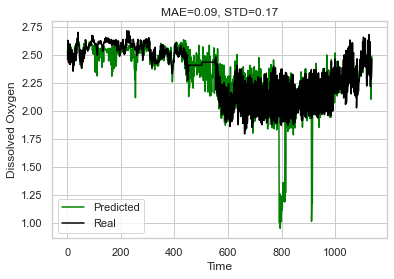

In [13]:
plt.plot(Y_pred, color='green', label='Predicted')
plt.plot(Y_test, color='black', label='Real')
plt.title(f"MAE={MAE:.2f}, STD={STD:.2f}")
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen')
plt.legend()
plt.savefig(f"{figsPath}/LSTM_{n_ahead}h.pdf", bbox_inches='tight')
plt.show()